# Experiment - Updated Comparision Models

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from preprocess import DataProcessor

In [ ]:
train_link = "/content/drive/My Drive/TEPdata/experiment_1/normal_10000.csv"
test_link =  "/content/drive/My Drive/TEPdata/experiment_2/TEP_multi_attack_offical.csv"


processor = DataProcessor(train_link, test_link, "Fault", "Unnamed: 0")
X_train = processor.X_train
y_train = processor.y_train
X_test = processor.X_test
y_test = processor.y_test
scaler = processor.scaler_function

## Evaluation Functions

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,roc_auc_score
def _precision(tp,fp):
    pre = tp / float(tp + fp)
    return pre 

def _recall(tp,fn):
    rec= tp / float(tp + fn)
    return rec 

def _f1(pre,rec):
    '''
    F1 = 2 * (precision * recall) / (precision + recall)
    '''
    f1 = 2 * (pre * rec) / (pre + rec)
    return f1

def print_results(accuracy, pre, rec, f1,roc):
    print("Accuracy: {}%".format(round(accuracy*100,2)))
    print("Precision: {}%".format(round(pre*100,2)))
    print("Recall: {}%".format(round(rec*100,2)))
    print("F1 Score: {}%".format(round(f1*100,2)))
    print("ROCAUC: {}%".format(round(roc*100,2)))
    
def calculate_results_print(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    accuracy = accuracy_score(y_test, y_pred)
    precision = _precision(TP,FP)
    recall = _recall(TP,FN)
    f1 = _f1(precision,recall)
    roc = roc_auc_score(y_test, y_pred)
    print_results(accuracy, precision, recall, f1,roc)

def _results(accuracy, pre, rec, f1,roc):
    acc = round(accuracy*100,2)
    precision = round(pre*100,2)
    recall = round(rec*100,2)
    f1_score = round(f1*100,2)
    roc_auc = round(roc*100,2)
    return [acc,precision, recall, f1_score, roc_auc]

def calculate_results_return(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    accuracy = accuracy_score(y_test, y_pred)
    precision = _precision(TP,FP)
    recall = _recall(TP,FN)
    f1 = _f1(precision,recall)
    roc = roc_auc_score(y_test, y_pred)
    acc,precision, recall, f1_score, roc_auc = _results(accuracy, precision, recall , f1, roc)
    return [acc,precision, recall, f1_score, roc_auc]

def result_dataframe(result_dict, y_test,fault):
        df = pd.DataFrame()
        for model in result_dict:
            res = calculate_results_return(y_test,  result_dict[model])
            df = df.append({"Fault": fault,'Model' : model, 'Accuracy': res[0], 'Precision': res[1], 'Recall': res[2], 'F1 Score': res[3], 'ROCAUC': res[4]}, ignore_index=True)
        return df 

def join_df(df_list):
    df = pd.concat(df_list, ignore_index=True)
    return df


# Proposed Model Pipeline

In [ ]:
from detector import *

In [ ]:
model_10k = AnomalyDetector()

In [ ]:
import torch
from tqdm import trange
import tqdm
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import logging

In [ ]:
model_10k  = torch.load('/content/b256_e10000_h25.pth')


In [ ]:
yp, det = model_10k.predict(X_test)


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
def find_optimal_threshold(y_test, y_pred):
        '''
        :param y_test: test target variable
        :param y_pred: predicted target variable
        :return: optimal threshold
        '''
        # get the false positive rate, true positive rate and thresholds
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        # get the optimal threshold based on the maximum tpr - fpr
        optimal_idx = np.argmax(tpr - fpr)
        # get the optimal threshold
        optimal_threshold = thresholds[optimal_idx]
        return optimal_threshold

def convert_scores_to_label(array, threshold):
    '''
    The function converts the scores to labels based on the threshold, if the score is greater than the threshold,
    the label is 1, else 0
    :param array: array of scores
    :param threshold: threshold to use for converting the scores to labels
    :return: array of labels
    '''
    binary = []
    for i in array:
        if i < threshold:
            binary.append(0)
        else:
            binary.append(1)
    return binary

#optimal = find_optimal_threshold(y_test, yp)
#y_pred = convert_scores_to_label(yp, optimal)

#calculate_results_print(y_test, y_pred )

In [ ]:
y_test.value_counts(normalize=True)

0    0.926983
1    0.073017
Name: Fault, dtype: float64

In [ ]:
print(y_test["Fault"].value_counts()[1] / len(y_test))

KeyError: ignored

In [ ]:
def fault_name(link):
    parts = link.split('/')
    filename = parts[-1]  # get the last part of the split string, which is the file name
    idv = filename.split('_')[-1].split('.')[0] # get the last part before the '.'
    return idv 
def run_experiment_lstm(link_test,y_test):
    fname = fault_name(link_test)
    processor = DataProcessor(train_link, link_test, "Fault", "Unnamed: 0")
    X_train = processor.X_train
    y_train = processor.y_train
    x_test = processor.X_test
    y_test = processor.y_test
    def test_models(x_test):
        yp, det = model_10k.predict(x_test)
        optimal = find_optimal_threshold(y_test, yp)
        y_pred = convert_scores_to_label(yp, optimal)
        results = {}
        results["Proposed Model"] = y_pred
        return results

    

    result_dict = test_models(x_test)
    predictions = result_dict
    predictions["y_true"] = list(y_test)
    result = result_dataframe(result_dict, y_test,fname)
    return result,  result_dict 

In [ ]:
results_lstm_idv1,y_preds_idv1 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(1).csv",y_test)
results_lstm_idv2,y_preds_idv2 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(2).csv",y_test)
results_lstm_idv3,y_preds_idv3 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(3).csv",y_test)
results_lstm_idv4,y_preds_idv4 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(4).csv",y_test)
results_lstm_idv5,y_preds_idv5 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(5).csv",y_test)
results_lstm_idv6,y_preds_idv6 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(6).csv",y_test)
results_lstm_idv7,y_preds_idv7 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(7).csv",y_test)
results_lstm_idv8,y_preds_idv8 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(8).csv",y_test)
results_lstm_idv9,y_preds_idv9 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(9).csv",y_test)
results_lstm_idv10,y_preds_idv10 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(10).csv",y_test)
results_lstm_idv11,y_preds_idv11 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(11).csv",y_test)
results_lstm_idv12,y_preds_idv12 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(12).csv",y_test)
results_lstm_idv13,y_preds_idv13 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(13).csv",y_test)
results_lstm_idv14,y_preds_idv14 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(14).csv",y_test)
results_lstm_idv15,y_preds_idv15 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(15).csv",y_test)
results_lstm_idv16,y_preds_idv16 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(16).csv",y_test)
results_lstm_idv17,y_preds_idv17 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(17).csv",y_test)
results_lstm_idv18,y_preds_idv18 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(18).csv",y_test)
results_lstm_idv19,y_preds_idv19 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(19).csv",y_test)
results_lstm_idv20,y_preds_idv20 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(20).csv",y_test)

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.for

In [ ]:
results_all_lstm = join_df([results_lstm_idv1, results_lstm_idv2, results_lstm_idv3, results_lstm_idv4, results_lstm_idv5,
                            results_lstm_idv6, results_lstm_idv7, results_lstm_idv8, results_lstm_idv9, results_lstm_idv10,
                            results_lstm_idv11, results_lstm_idv12, results_lstm_idv13, results_lstm_idv14, results_lstm_idv15,
                            results_lstm_idv16, results_lstm_idv17, results_lstm_idv18, results_lstm_idv19, results_lstm_idv20
                            ])


results_lstm_15_types = join_df([results_lstm_idv1, results_lstm_idv2, results_lstm_idv4, results_lstm_idv5,
                            results_lstm_idv6, results_lstm_idv8, results_lstm_idv10,
                            results_lstm_idv11, results_lstm_idv13, results_lstm_idv14,
                            results_lstm_idv16, results_lstm_idv17, results_lstm_idv19, results_lstm_idv20
                            ])


In [ ]:
def convert_dict_to_df(dictionary,y_true, fault):
    dictionary["y_true"] = y_true
    df=pd.DataFrame.from_dict(dictionary,orient='index').transpose()
    df["Fault"] = fault
    return df
y_preds_idv1 = convert_dict_to_df(y_preds_idv1,y_test, "IDV(1)")
y_preds_idv2 = convert_dict_to_df(y_preds_idv2,y_test, "IDV(2)")
y_preds_idv3 = convert_dict_to_df(y_preds_idv3,y_test, "IDV(3)")
y_preds_idv4 = convert_dict_to_df(y_preds_idv4,y_test, "IDV(4)")
y_preds_idv5 = convert_dict_to_df(y_preds_idv5,y_test, "IDV(5)")
y_preds_idv6 = convert_dict_to_df(y_preds_idv6,y_test, "IDV(6)")
y_preds_idv7 = convert_dict_to_df(y_preds_idv7,y_test, "IDV(7)")
y_preds_idv8 = convert_dict_to_df(y_preds_idv8,y_test, "IDV(8)")
y_preds_idv9 = convert_dict_to_df(y_preds_idv9,y_test, "IDV(9)")
y_preds_idv10 = convert_dict_to_df(y_preds_idv10,y_test, "IDV(10)")
y_preds_idv11 = convert_dict_to_df(y_preds_idv11,y_test, "IDV(11)")
y_preds_idv12 = convert_dict_to_df(y_preds_idv12,y_test, "IDV(12)")
y_preds_idv13 = convert_dict_to_df(y_preds_idv13,y_test, "IDV(13)")
y_preds_idv14 = convert_dict_to_df(y_preds_idv14,y_test, "IDV(14)")
y_preds_idv15 = convert_dict_to_df(y_preds_idv15,y_test, "IDV(15)")
y_preds_idv16 = convert_dict_to_df(y_preds_idv16,y_test, "IDV(16)")
y_preds_idv17 = convert_dict_to_df(y_preds_idv17,y_test, "IDV(17)")
y_preds_idv18 = convert_dict_to_df(y_preds_idv18,y_test, "IDV(18)")
y_preds_idv19 = convert_dict_to_df(y_preds_idv19,y_test, "IDV(19)")
y_preds_idv20 = convert_dict_to_df(y_preds_idv20,y_test, "IDV(20)")

In [ ]:
results_pred_lstm_all = join_df([y_preds_idv1, y_preds_idv2, y_preds_idv3, y_preds_idv4, y_preds_idv5,
                                 y_preds_idv6, y_preds_idv7, y_preds_idv8, y_preds_idv9, y_preds_idv10,
                                 y_preds_idv11, y_preds_idv12, y_preds_idv13, y_preds_idv14, y_preds_idv15,
                                 y_preds_idv16, y_preds_idv17, y_preds_idv18, y_preds_idv19, y_preds_idv20])

results_pred_lstm_15 = join_df([y_preds_idv1, y_preds_idv2, y_preds_idv4, y_preds_idv5,
                                 y_preds_idv6, y_preds_idv8, y_preds_idv10,
                                 y_preds_idv11, y_preds_idv13, y_preds_idv14,
                                 y_preds_idv16, y_preds_idv17, y_preds_idv19, y_preds_idv20])

In [ ]:
abc

,Proposed Model,y_true,Fault
0,0,0,IDV(1)
1,0,0,IDV(1)
2,0,0,IDV(1)
3,0,0,IDV(1)
4,0,0,IDV(1)
...,...,...,...
19995,0,0,IDV(2)
19996,0,0,IDV(2)
19997,0,0,IDV(2)
19998,0,0,IDV(2)


In [ ]:
def result_table(df):
    res = df.groupby(['Model'])
    return res.mean() 
    
res = result_table(results_lstm_15_types)
res

,Accuracy,Precision,Recall,F1 Score,ROCAUC
Model,,,,,
Proposed Model,91.589286,92.225714,98.168571,95.034286,89.473571


In [ ]:
results_lstm_15_types.to_csv("experiment_results_lstm_15_types.csv")
results_all_lstm.to_csv("experiment_results_all_lstm.csv")

In [ ]:
results_pred_lstm_15.to_csv("experiment_results_lstm_15_pred.csv")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
def make_confusion_matrix(y_true, y_prediction, normalise = False, c_map = "viridis"):
    sns.set(font_scale=1.2)
    plt.figure(figsize=(8, 6))
    ax = plt.axes()
    ax.set_title('Proposed Model')
    cm = confusion_matrix(y_true, y_prediction)
    format = "d"
    if normalise== True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        format = '.4f'
    cm_matrix = pd.DataFrame(data=cm, columns=['Normal', 'Attack'], 
                                index=['Normal', 'Attack'])

    sns.heatmap(cm_matrix, annot=True, fmt=format, cmap=c_map,linewidths=1, linecolor='black',clip_on=False)
    plt.savefig("cm_proposed.png", transparent = False)
    plt.show()

#make_confusion_matrix(results_pred_lstm_15["y_true"],results_pred_lstm_15["Proposed Model"] , True, c_map = "Blues")

In [ ]:

calculate_results_print(results_pred_lstm_15["y_true"],results_pred_lstm_15["Proposed Model"] )

Accuracy: 90.5%
Precision: 91.45%
Recall: 97.66%
F1 Score: 94.45%
ROCAUC: 87.34%


In [ ]:
def get_attacks(y_test, outlier=1, normal=0, breaks=[]):
    '''
    Get indices of anomalies
    :param y_test: predictions from semi supervised model
    :param outlier: label for anomalies
    :param normal: label for normal data points
    :param breaks: indices of breaks in data
    :return: 
    '''
    events = dict()
    label_prev = normal
    event = 0  # corresponds to no event
    event_start = 0
    for tim, label in enumerate(y_test):
        if label == outlier:
            if label_prev == normal:
                event += 1
                event_start = tim
            elif tim in breaks:
                # A break point was hit, end current event and start new one
                event_end = tim - 1
                events[event] = (event_start, event_end)
                event += 1
                event_start = tim

        else:
            # event_by_time_true[tim] = 0
            if label_prev == outlier:
                event_end = tim - 1
                events[event] = (event_start, event_end)
        label_prev = label

    if label_prev == outlier:
        event_end = tim - 1
        events[event] = (event_start, event_end)
    return events

#dict_attacks = get_attacks(y_test, outlier=1, normal=0, breaks=[])
#dict_attacks1 = get_attacks(y_predictions, outlier=1, normal=0, breaks=[])

def get_attack_idx_list(dictionary):
    '''
    Get list of indices of anomalies
    :param dictionary: dictionary of anomalies
    :return: Dictionary of anomalies, value is changed from (start, end) to list of indices
    '''
    for key, value in dictionary.items():
        if isinstance(value, tuple):
            dictionary[key] = list(range(value[0], value[1] + 1))
    return dictionary

dict_attacks = get_attacks(y_test, outlier=1, normal=0, breaks=[])
dict_attacks1 = get_attacks(y_pred, outlier=1, normal=0, breaks=[])
attacks = get_attack_idx_list(dict_attacks)
attacks1 = get_attack_idx_list(dict_attacks1)

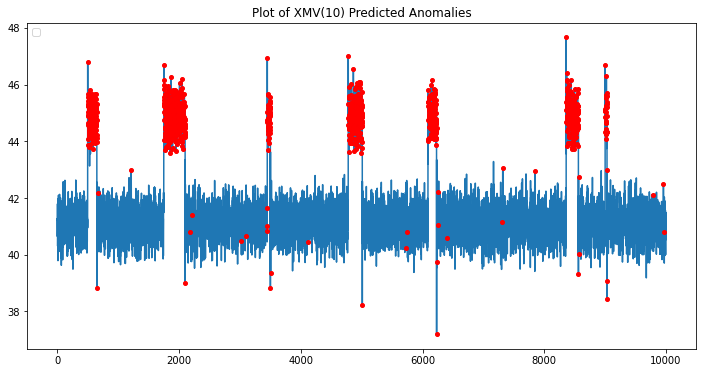

In [ ]:
import matplotlib.pyplot as plt
def plot_anomalies(df, column, anomalies,scaler = None):
    '''
    Plot anomalies
    :param df: dataframe to plot
    :param column: column to plot
    :param anomalies: dictionary of anomalies -> pass through dictionary - list pipeline to get dictionary with indx of anomalies
    :param reverse_scaler: object used to scale the data -> reverses to original scale in plot of passed
    '''
    if scaler is not None:
      df = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    title = "Plot of {} Predicted Anomalies".format(column)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df[column])
    ax.set_title(title)
    for key, value in anomalies.items():
        ax.plot(value, df[column][value], 'ro', markersize=4)
    ax.set_label('Inline label')
    plt.show()
plot_anomalies(X_test,"XMV(10)",attacks1, scaler)

In [ ]:
train_link = "/content/drive/My Drive/TEPdata/experiment_1/normal_10000.csv"
test_link =  "/content/drive/My Drive/TEPdata/experiment_2/TEP_multi_attack_offical.csv"

model_10k  = torch.load('/content/b256_e10000_h25.pth')

processor = DataProcessor(train_link, test_link, "Fault", "Unnamed: 0")
X_train = processor.X_train
y_train = processor.y_train
X_test = processor.X_test
y_test = processor.y_test
yp, det = model_10k.predict(X_test)
optimal = find_optimal_threshold(y_test, yp)
y_pred = convert_scores_to_label(yp, optimal)


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


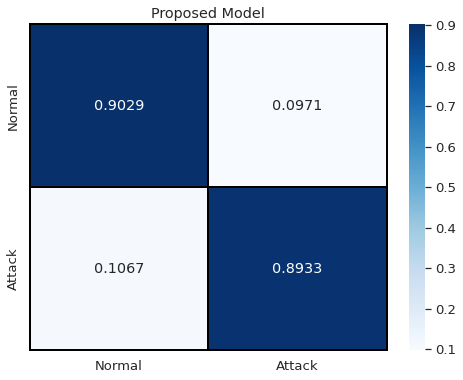

In [ ]:
make_confusion_matrix(y_test,y_pred , True, c_map = "Blues")